In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
total_viviendas = 33_162_148

In [3]:
f = '../data/001_raw/ENCEVI_2018/vivienda.csv'
entidad = pd.read_csv(f,usecols=['folio','entidad'],index_col=0)

In [4]:
f ="../data/002_intermediate/vivienda_con_aa.parquet"
viv =pd.read_parquet(f)
viv.factor.sum()

viv = viv.join(entidad,how='inner')
viv = viv[viv['entidad']==19]
del viv['entidad']
viv

,clima,factor,personas,m2,estrato,kwh_mes,kwh_m2,kwh_persona,kwh_m2persona
folio,,,,,,,,,
16082,Cálido extremoso,1778,4,100.0,Medio bajo,91.972790,1.778141,44.453515,0.444535
16087,Cálido extremoso,1413,2,100.0,Medio alto,770.600719,7.192273,359.613669,3.596137
16088,Cálido extremoso,1413,2,100.0,Medio alto,47.375451,0.915925,45.796270,0.457963
16089,Cálido extremoso,1413,5,150.0,Medio alto,213.275324,2.796276,83.888294,0.559255
16090,Cálido extremoso,1413,2,100.0,Medio alto,91.219720,1.946021,97.301035,0.973010
...,...,...,...,...,...,...,...,...,...
16943,Cálido extremoso,940,5,55.0,Bajo,58.144420,2.149582,23.645397,0.429916
16945,Cálido extremoso,940,3,100.0,Bajo,129.134483,2.410510,80.350345,0.803503
16951,Cálido extremoso,940,3,100.0,Bajo,126.895967,2.537919,84.597311,0.845973


In [5]:
viv

,clima,factor,personas,m2,estrato,kwh_mes,kwh_m2,kwh_persona,kwh_m2persona
folio,,,,,,,,,
16082,Cálido extremoso,1778,4,100.0,Medio bajo,91.972790,1.778141,44.453515,0.444535
16087,Cálido extremoso,1413,2,100.0,Medio alto,770.600719,7.192273,359.613669,3.596137
16088,Cálido extremoso,1413,2,100.0,Medio alto,47.375451,0.915925,45.796270,0.457963
16089,Cálido extremoso,1413,5,150.0,Medio alto,213.275324,2.796276,83.888294,0.559255
16090,Cálido extremoso,1413,2,100.0,Medio alto,91.219720,1.946021,97.301035,0.973010
...,...,...,...,...,...,...,...,...,...
16943,Cálido extremoso,940,5,55.0,Bajo,58.144420,2.149582,23.645397,0.429916
16945,Cálido extremoso,940,3,100.0,Bajo,129.134483,2.410510,80.350345,0.803503
16951,Cálido extremoso,940,3,100.0,Bajo,126.895967,2.537919,84.597311,0.845973


In [6]:

# --- 1) Función para calcular cuantiles ponderados ---
def cuantil_ponderado(valores, percentiles, pesos):
    v = np.array(valores)
    w = np.array(pesos)
    orden = np.argsort(v)
    v_ord, w_ord = v[orden], w[orden]
    cumw = np.cumsum(w_ord)
    cumw_norm = cumw / cumw[-1]
    return np.interp(percentiles, cumw_norm, v_ord)

# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes(df):
    vals = df['kwh_mes'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })


# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes_persona(df):
    vals = df['kwh_persona'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })
# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes_persona_area(df):
    vals = df['kwh_m2persona'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })

In [7]:
f = "../data/002_intermediate/porcentajes_aa.parquet"
porcentajes_aa = pd.read_parquet(f)

In [8]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes)
    .reset_index()
)
grouped =  pd.concat([grouped,porcentajes_aa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmes = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75',"porcentaje"]]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |   porcentaje |
|-------:|-------:|----------:|--------:|-------:|-------------:|
|  30.00 | nan    |    nan    |  nan    | nan    |       nan    |
|  55.00 |  46.59 |     48.06 |   53.21 |  53.10 |         0.03 |
|  75.00 |  49.50 |     51.96 |   65.28 |  59.49 |         0.01 |
| 100.00 | 126.90 |    128.02 |  200.79 | 183.44 |         0.05 |
| 150.00 | nan    |    nan    |  nan    | nan    |       nan    |
| 200.00 | 176.80 |    176.80 |  176.80 | 176.80 |         0.01 |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |    P25 |   Mediana |   Media |    P75 |   porcentaje |
|-------:|-------:|----------:|--------:|-------:|-------------:|
|  30.00 | nan    |    nan    |  nan    | nan    |       nan    |
|  55.00 |  85.93 |    133.17 |  152.38 | 153.89 |         0.12 |
|  75.00 |  69.73 |     82.86 |  101.69 | 113.54 |      

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_4617/2173147482.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes)


In [9]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes_persona)
    .reset_index()
)


grouped =  pd.concat([grouped,porcentajes_aa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmespersona = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75']]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 | nan    |    nan    |  nan    | nan    |
|  55.00 |  23.30 |     23.34 |   23.50 |  23.49 |
|  75.00 |  20.13 |     33.93 |   40.38 |  50.06 |
| 100.00 |  78.25 |     79.30 |   81.06 |  81.41 |
| 150.00 | nan    |    nan    |  nan    | nan    |
| 200.00 | 119.83 |    119.83 |  119.83 | 119.83 |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 | nan    |    nan    |  nan    | nan    |
|  55.00 |  39.89 |     56.16 |   69.88 |  81.24 |
|  75.00 |  34.45 |     49.62 |   65.93 |  72.43 |
| 100.00 |  33.54 |     47.74 |   68.98 |  66.90 |
| 150.00 |  34.80 |     57.78 |   94.97 | 101.98 |
| 200.00 |  32.73 |     43.56 |  110.32 |  95.77 |
: Estadísticas ponderadas de con

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_4617/954292148.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes_persona)


In [10]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes_persona_area)
    .reset_index()
)


grouped =  pd.concat([grouped,porcentajes_aa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmespersonaarea = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75']]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 | nan    |    nan    |  nan    | nan    |
|  55.00 |   0.42 |      0.42 |    0.43 |   0.43 |
|  75.00 |   0.27 |      0.45 |    0.54 |   0.67 |
| 100.00 |   0.78 |      0.79 |    0.81 |   0.81 |
| 150.00 | nan    |    nan    |  nan    | nan    |
| 200.00 |   0.60 |      0.60 |    0.60 |   0.60 |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 | nan    |    nan    |  nan    | nan    |
|  55.00 |   0.73 |      1.02 |    1.27 |   1.48 |
|  75.00 |   0.46 |      0.66 |    0.88 |   0.97 |
| 100.00 |   0.34 |      0.48 |    0.69 |   0.67 |
| 150.00 |   0.23 |      0.39 |    0.63 |   0.68 |
| 200.00 |   0.16 |      0.22 |    0.55 |   0.48 |
: Estadísticas ponderadas de con

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_4617/12594808.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes_persona_area)


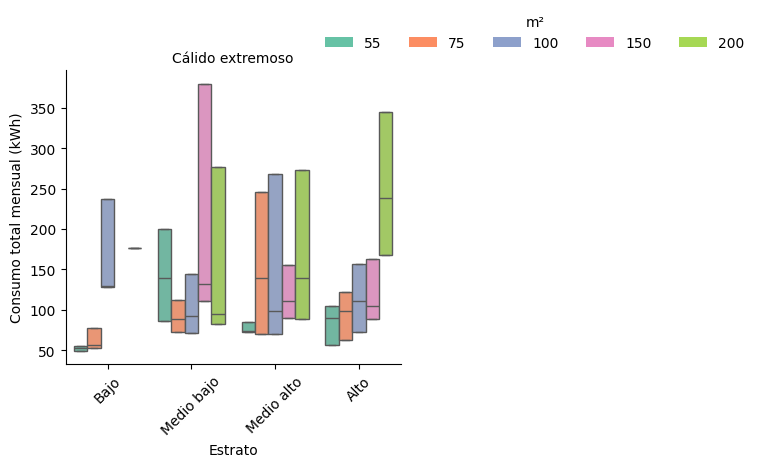

In [11]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_mes',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual (kWh)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


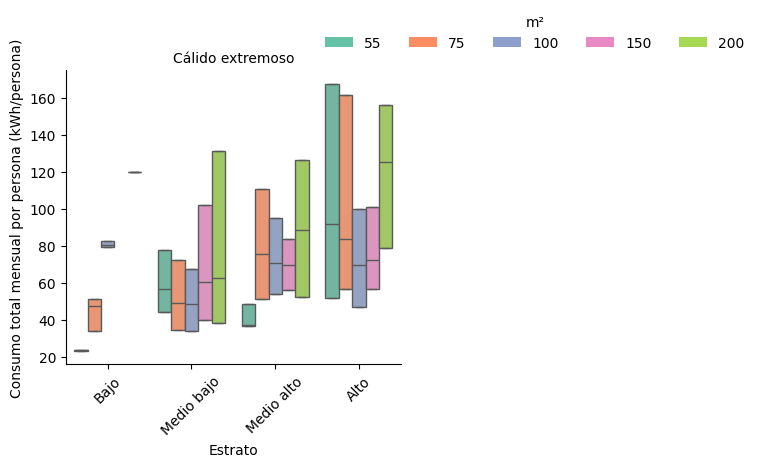

In [12]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual por persona (kWh/persona)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


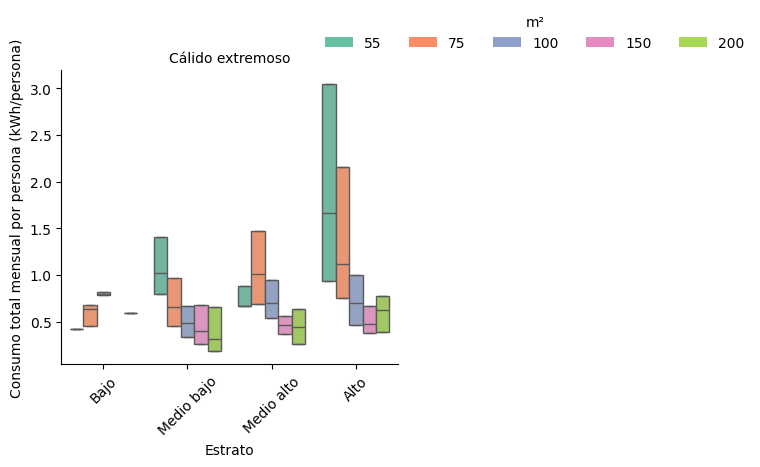

In [13]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_m2persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual por persona (kWh/persona)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


In [14]:
grouped_kwhmes["etotal"] = grouped_kwhmes.Media*grouped_kwhmes.viviendas
grouped_kwhmes.sort_values(by="etotal",ascending=False)

,m2,clima,estrato,P25,Mediana,Media,P75,porcentaje,viviendas,etotal
13,150.0,Cálido extremoso,Medio alto,87.115769,110.745026,139.653661,148.281147,0.646143,214275.0,2.992429e+07
12,150.0,Cálido extremoso,Alto,84.462597,103.969151,166.797558,159.319613,0.228619,75815.0,1.264576e+07
3,55.0,Cálido extremoso,Medio bajo,85.928051,133.172090,152.381742,153.890123,0.119676,39687.0,6.047574e+06
10,100.0,Cálido extremoso,Medio alto,68.914369,97.966070,166.693923,266.687700,0.100199,33228.0,5.538906e+06
11,100.0,Cálido extremoso,Medio bajo,70.664103,93.530096,130.921308,144.277214,0.086041,28533.0,3.735578e+06
...,...,...,...,...,...,...,...,...,...,...
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027016,8959.0,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037597,12468.0,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012427,4121.0,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050618,16786.0,NaN


In [15]:
# Opción 1: Seleccionar las 4 columnas tras ordenar
df_vis = (
    grouped_kwhmes
      .sort_values(by="etotal", ascending=False)
      [["m2","clima","estrato","viviendas","etotal"]]
      .reset_index(drop=True)
)
display(df_vis)


,m2,clima,estrato,viviendas,etotal
0,150.0,Cálido extremoso,Medio alto,214275.0,2.992429e+07
1,150.0,Cálido extremoso,Alto,75815.0,1.264576e+07
2,55.0,Cálido extremoso,Medio bajo,39687.0,6.047574e+06
3,100.0,Cálido extremoso,Medio alto,33228.0,5.538906e+06
4,100.0,Cálido extremoso,Medio bajo,28533.0,3.735578e+06
...,...,...,...,...,...
63,NaN,NaN,NaN,8959.0,NaN
64,NaN,NaN,NaN,12468.0,NaN
65,NaN,NaN,NaN,4121.0,NaN
66,NaN,NaN,NaN,16786.0,NaN


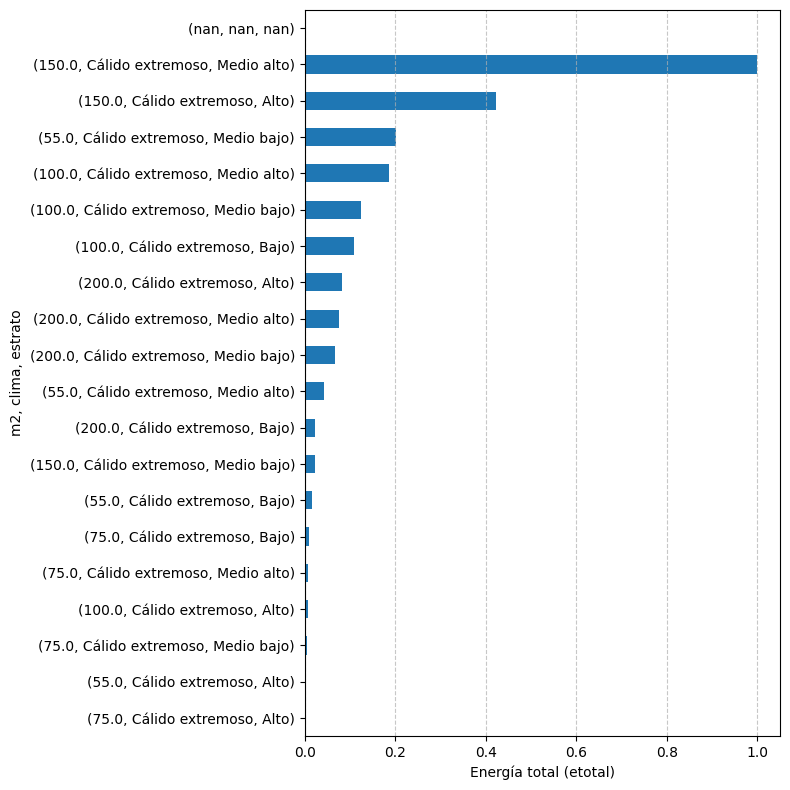

In [16]:

# Prepara Serie normalizada (ya la tienes)
et = (
    grouped_kwhmes
      .sort_values(by="etotal", ascending=False)
      .set_index(["m2","clima","estrato"])["etotal"]
      .head(20)
)
et = et / et.max()

# Grafica horizontal
plt.figure(figsize=(8, 8))
# Para que la barra más grande quede arriba, ordena de menor a mayor
et.sort_values().plot(kind='barh')

plt.xlabel("Energía total (etotal)")
plt.ylabel("m2, clima, estrato")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
grouped_kwhmes

,m2,clima,estrato,P25,Mediana,Media,P75,porcentaje,viviendas,etotal
0,55.0,Cálido extremoso,Alto,23.286239,55.364100,77.365501,96.734238,0.003353,1112.0,8.603044e+04
1,55.0,Cálido extremoso,Bajo,46.592573,48.061132,53.209719,53.102776,0.028499,9451.0,5.028851e+05
2,55.0,Cálido extremoso,Medio alto,71.756905,72.924205,81.731623,81.686040,0.046803,15521.0,1.268557e+06
3,55.0,Cálido extremoso,Medio bajo,85.928051,133.172090,152.381742,153.890123,0.119676,39687.0,6.047574e+06
4,75.0,Cálido extremoso,Alto,58.864748,84.993635,134.090398,120.916597,0.000645,214.0,2.869535e+04
...,...,...,...,...,...,...,...,...,...,...
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027016,8959.0,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037597,12468.0,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012427,4121.0,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050618,16786.0,NaN


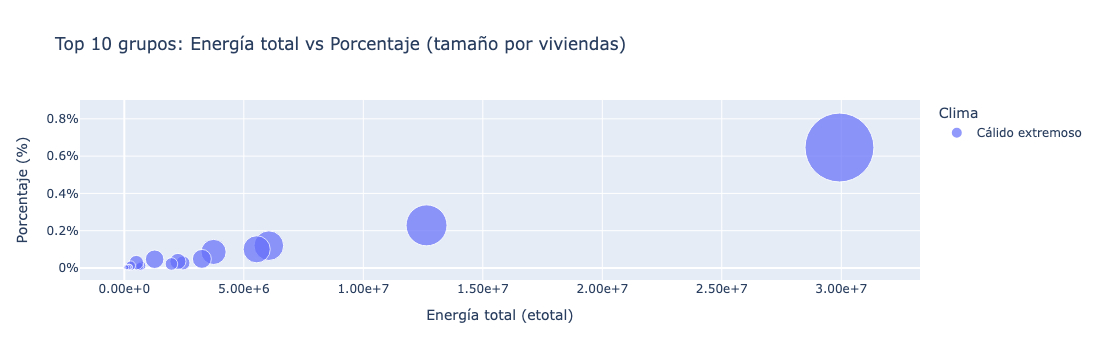

In [18]:

# Ordenar y seleccionar top 10 grupos por etotal
df_top10 = (
    grouped_kwhmes
    .sort_values(by='etotal', ascending=False)
    # .head(30)
    .reset_index()
)

# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    df_top10,
    x='etotal',
    y='porcentaje',
    size='viviendas',
    color='clima',
    hover_data=['m2', 'estrato', 'viviendas', 'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (etotal)',
        'porcentaje': 'Porcentaje (%)',
        'viviendas': 'Número de viviendas',
        'clima': 'Clima'
    },
    title='Top 10 grupos: Energía total vs Porcentaje (tamaño por viviendas)',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(ticksuffix="%")
)

fig.show()


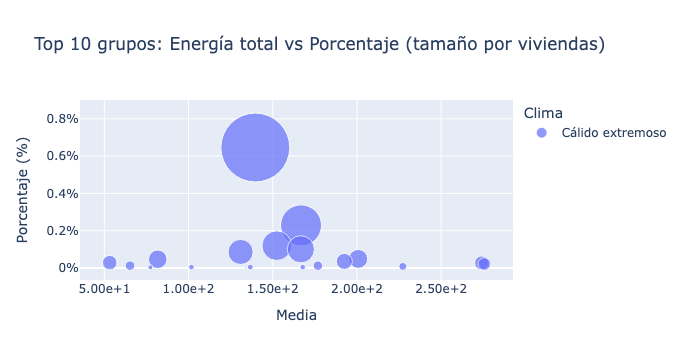

In [19]:

# Ordenar y seleccionar top 10 grupos por etotal
df_top10 = (
    grouped_kwhmes
    .sort_values(by='etotal', ascending=False)
    # .head(30)
    .reset_index()
)

# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    df_top10,
    x='Media',
    y='porcentaje',
    size='viviendas',
    color='clima',
    hover_data=['m2', 'estrato', 'viviendas', 'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (etotal)',
        'porcentaje': 'Porcentaje (%)',
        'viviendas': 'Número de viviendas',
        'clima': 'Clima'
    },
    title='Top 10 grupos: Energía total vs Porcentaje (tamaño por viviendas)',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(ticksuffix="%")
)

fig.show()
